In [ ]:
import tensorflow as tf
import numpy as np
import os
import sys
import cv2
import matplotlib.pyplot as plt


from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, UpSampling2D, Concatenate, ZeroPadding2D, Add, AveragePooling2D, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from glob import glob
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras import backend as K
from tensorflow.keras.initializers import glorot_uniform
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd drive/MyDrive/Semantic/
!ls

/content/drive/MyDrive/Semantic
Augmented  CXR_png  masks  ResNet50Aug.h5  ResNet50.h5


In [ ]:
mask_path = "./Augmented/Masks/"
train_path = "./Augmented/Images/"

mask_ids = next(os.walk(mask_path))[2]
masks = [os.path.join(mask_path, f"{name}") for name in mask_ids]
train_ids = next(os.walk(train_path))[2]
train = [os.path.join(train_path, f"{name}") for name in train_ids]

In [ ]:
print(len(train))
print(len(masks))

1263
1263


In [ ]:
train = sorted(train)
masks = sorted(masks)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(train, masks, test_size=0.2, random_state=42)
print(len(x_train), len(x_test), len(y_train), len(y_test))

1010 253 1010 253


In [ ]:
def read_image(x, W=1024, H=1024):
    x = cv2.imread(x, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (W,H))
    x = cv2.cvtColor(x, cv2.COLOR_BGR2GRAY)
    x = x/255.0
    x = x.astype(np.float32)
    x = np.expand_dims(x, axis=-1)
    return x

def preprocess(x, y, W=1024, H=1024):
    def f(x,y):
        x = x.decode()
        y = y.decode()
        
        image = read_image(x)
        mask = read_image(y)
        return image, mask
    image, mask = tf.numpy_function(f, [x,y], [tf.float32,tf.float32])
    image.set_shape([H,W,1])
    mask.set_shape([H,W,1])
    return image, mask

In [ ]:
def tf_dataset(x,y,batch_size=1):
    data = tf.data.Dataset.from_tensor_slices((x,y))
    #data = data.shuffle(buffer_size=5000)
    data = data.map(preprocess)
    data = data.batch(batch_size)
    data = data.repeat()
    data = data.prefetch(2)
    return data

In [ ]:
train_dataset = tf_dataset(x_train,y_train)
test_dataset = tf_dataset(x_test, y_test)

In [ ]:
print(train_dataset)

<PrefetchDataset shapes: ((None, 1024, 1024, 1), (None, 1024, 1024, 1)), types: (tf.float32, tf.float32)>


In [ ]:
def read2rgb(x):
    x = cv2.imread(x)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    return x

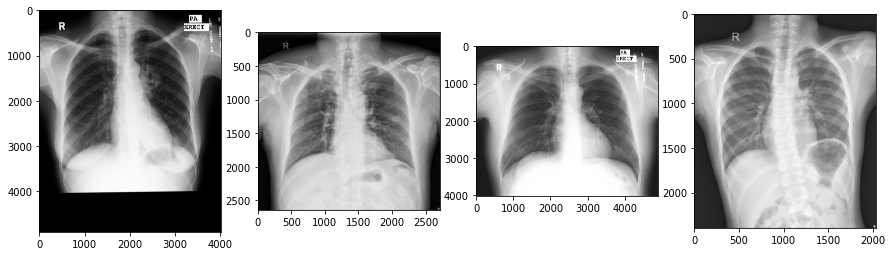

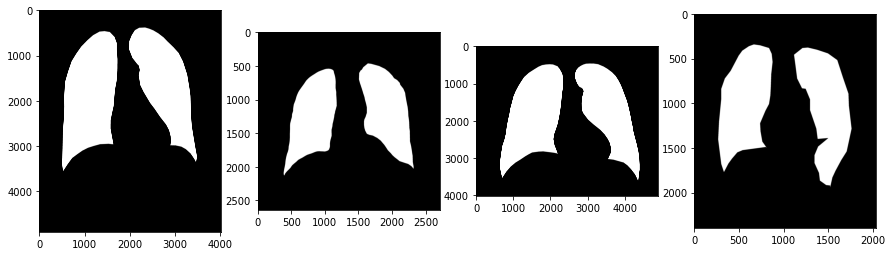

In [ ]:
train_x = train
train_y = masks

fig = plt.figure(figsize=(15,15))

a = fig.add_subplot(1,4,1)
imgplot = plt.imshow(read2rgb(train_x[6]))

a = fig.add_subplot(1,4,2)
imgplot = plt.imshow(read2rgb(train_x[10]))
imgplot.set_clim(0.0,0.7)

a = fig.add_subplot(1,4,3)
imgplot = plt.imshow(read2rgb(train_x[8]))
imgplot.set_clim(0.0,1.4)

a = fig.add_subplot(1,4,4)
imgplot = plt.imshow(read2rgb(train_x[15]))
imgplot.set_clim(0.0,2.1)

fig = plt.figure(figsize=(15,15))

a = fig.add_subplot(1,4,1)
imgplot = plt.imshow(read2rgb(train_y[6]))

a = fig.add_subplot(1,4,2)
imgplot = plt.imshow(read2rgb(train_y[10]))
imgplot.set_clim(0.0,0.7)

a = fig.add_subplot(1,4,3)
imgplot = plt.imshow(read2rgb(train_y[8]))
imgplot.set_clim(0.0,1.4)

a = fig.add_subplot(1,4,4)
imgplot = plt.imshow(read2rgb(train_y[15]))
imgplot.set_clim(0.0,2.1)

In [ ]:
# Block for ResNet

def identity_block(x, f, filters, stage, block):
    
    conv_name = 'res' + str(stage) + block + '_branch'
    bn_name = 'bn' + str(stage) + block + '_branch'
    
    F1, F2, F3 = filters
    
    x_shortcut = x
    
    x = Conv2D(filters=F1, kernel_size=(1,1), strides=(1,1), padding="valid", name=conv_name+'2a', kernel_initializer=glorot_uniform(seed=0))(x)
    x = BatchNormalization(axis=3, name=bn_name+'2a')(x)
    x = Activation("relu")(x)
    
    x = Conv2D(filters=F2, kernel_size=(f,f), strides=(1,1), padding="same", name=conv_name+'2b', kernel_initializer=glorot_uniform(seed=0))(x)
    x = BatchNormalization(axis=3, name=bn_name+'2b')(x)
    x = Activation("relu")(x)
    
    x = Conv2D(filters=F3, kernel_size=(1,1), strides=(1,1), padding="valid", name=conv_name+'2c', kernel_initializer=glorot_uniform(seed=0))(x)
    x = BatchNormalization(axis=3, name=bn_name+'2c')(x)
    
    x = Add()([x,x_shortcut])
    x = Activation('relu')(x)
    
    return x

In [ ]:
def convolutional_block(x, f, filters, stage, block, s=2):
   
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    F1, F2, F3 = filters

    x_shortcut = x

    x = Conv2D(filters=F1, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(x)
    x = BatchNormalization(axis=3, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(x)
    x = BatchNormalization(axis=3, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(x)
    x = BatchNormalization(axis=3, name=bn_name_base + '2c')(x)

    x_shortcut = Conv2D(filters=F3, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '1', kernel_initializer=glorot_uniform(seed=0))(x_shortcut)
    x_shortcut = BatchNormalization(axis=3, name=bn_name_base + '1')(x_shortcut)

    x = Add()([x, x_shortcut])
    x = Activation('relu')(x)

    return x

In [ ]:
def conv_block(inputs, no):
    
    x = Conv2D(no, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    x = Conv2D(no, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    return x

In [ ]:
def decoder_block(inputs, skip_features, no):
    
    x = Conv2DTranspose(no, (2,2), strides=(2,2), padding="same")(inputs)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, no)
    
    return x

In [ ]:
def Resnet50(input_shape=(1024, 1024, 1)):
    
    # Input
    X_input = Input(input_shape)
    
    # ResNet50 Model (Encoder)

    X1 = ZeroPadding2D((3, 3))(X_input)

    X1 = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X1)
    X1 = BatchNormalization(axis=3, name='bn_conv1')(X1)
    X1n = Activation('relu')(X1)
    X1 = ZeroPadding2D()(X1n)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X1)

    X2 = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X2 = identity_block(X2, 3, [64, 64, 256], stage=2, block='b')
    X2 = identity_block(X2, 3, [64, 64, 256], stage=2, block='c')

    
    X3 = convolutional_block(X2, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
    X3 = identity_block(X3, 3, [128, 128, 512], stage=3, block='b')
    X3 = identity_block(X3, 3, [128, 128, 512], stage=3, block='c')
    X3 = identity_block(X3, 3, [128, 128, 512], stage=3, block='d')
    
    X4 = convolutional_block(X3, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
    X4 = identity_block(X4, 3, [256, 256, 1024], stage=4, block='b')
    X4 = identity_block(X4, 3, [256, 256, 1024], stage=4, block='c')
    X4 = identity_block(X4, 3, [256, 256, 1024], stage=4, block='d')
    X4 = identity_block(X4, 3, [256, 256, 1024], stage=4, block='e')
    X4 = identity_block(X4, 3, [256, 256, 1024], stage=4, block='f')

    X5 = convolutional_block(X4, f=3, filters=[512, 512, 2048], stage=5, block='a', s=2)
    X5 = identity_block(X5, 3, [512, 512, 2048], stage=5, block='b')
    X5 = identity_block(X5, 3, [512, 512, 2048], stage=5, block='c')
    

    # X5 = AveragePooling2D(pool_size=(2, 2), padding='same')(X5)
    
    # Skip connections
    
    s1 = X_input
    s2 = X1n
    s3 = X2
    s4 = X3
    
    # Bridge
    
    b = X4
    
    # Decoder
    
    d1 = decoder_block(b, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 64)
    d4 = decoder_block(d3, s1, 3)
    
    out = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)
    
    
    # print(s1.shape, s2.shape, s3.shape, s4.shape, b.shape, d1.shape, d2.shape, d3.shape, d4.shape)
    
    model = Model(inputs=X_input, outputs=out)

    return model

In [ ]:
net = Resnet50((1024,1024,1))
net.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1024, 1024,  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 1030, 1030, 1 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 512, 512, 64) 3200        zero_padding2d[0][0]             
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 512, 512, 64) 256         conv1[0][0]                      
______________________________________________________________________________________________

In [ ]:
smooth = 1e-15

def dice_coefficent(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    
    intersection = tf.reduce_sum(y_true*y_pred)
    return (2*intersection + smooth)/ (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def loss(y_true, y_pred):
    return 1 - dice_coefficent(y_true, y_pred)

In [ ]:
lr = 1e-4
opt = tf.keras.optimizers.Adam(lr)
metrics = [dice_coefficent, Recall(), Precision()]

In [ ]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

In [ ]:
def create_mask(pred_mask):
  res = pred_mask[-1,:,:]
  res = cv2.cvtColor(res, cv2.COLOR_BGR2RGB)
  return res

In [ ]:
def show_predictions(dataset=None, num=1):
  if train_dataset:
    for image, mask in train_dataset.take(num):
      pred_mask = net.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(net.predict(sample_image[tf.newaxis, ...]))])

In [ ]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [ ]:
callbacks = [
    ModelCheckpoint("./ResNet50Aug.h5", verbose=1, save_best_model=True),
    ReduceLROnPlateau(monitor="val_loss", patience=3, factor=0.1, verbose=1, min_lr=1e-6),
    EarlyStopping(monitor="val_loss", patience=5, verbose=1),
    DisplayCallback()
]

In [ ]:
net = tf.keras.models.load_model('./ResNet50Aug.h5', custom_objects={'dice_coefficent':dice_coefficent, 'loss':loss})

In [ ]:
net.compile(loss=loss,optimizer=opt, metrics=metrics)

In [ ]:
from IPython.display import clear_output

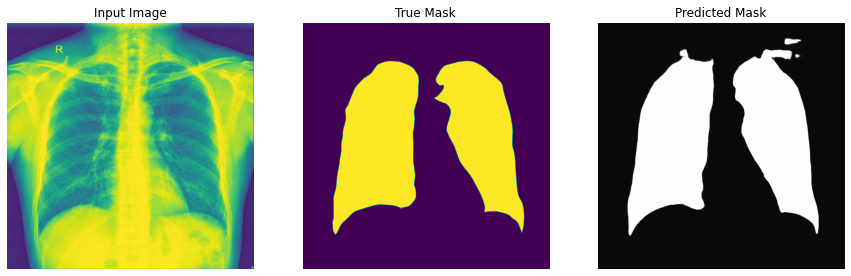


Sample Prediction after epoch 3



In [ ]:
history = net.fit(
    train_dataset,
    steps_per_epoch=len(x_train),
    epochs=3,
    callbacks=callbacks, 
    validation_data=test_dataset, 
    validation_steps=len(x_test)
  )

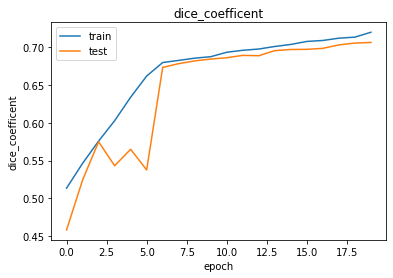

In [ ]:
plt.plot(history.history['dice_coefficent'])
plt.plot(history.history['val_dice_coefficent'])
plt.title('dice_coefficent')
plt.ylabel('dice_coefficent')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

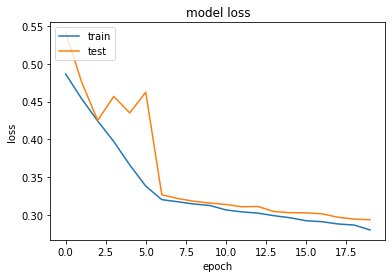

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

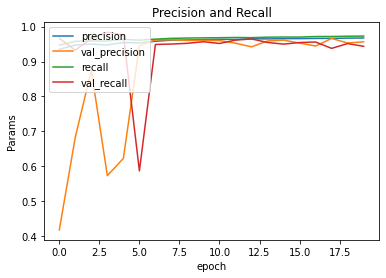

In [ ]:
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('Precision and Recall')
plt.ylabel('Params')
plt.xlabel('epoch')
plt.legend(['precision', 'val_precision', 'recall', 'val_recall'], loc='upper left')
plt.show()

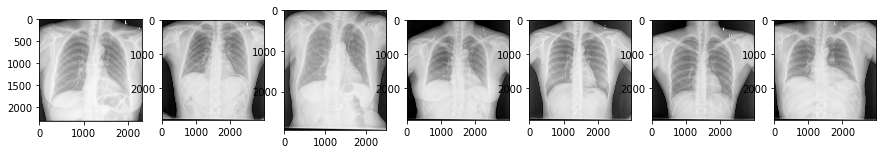

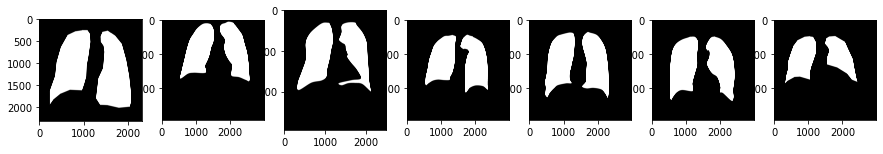

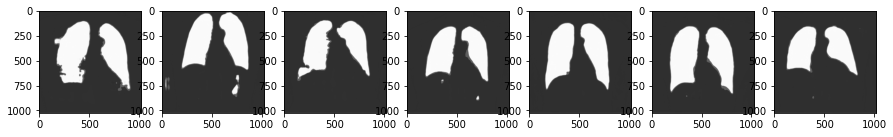

In [ ]:
fig = plt.figure(figsize=(15,15))

a = fig.add_subplot(1,7,1)
imgplot = plt.imshow(read2rgb(train_x[6]))

a = fig.add_subplot(1,7,2)
imgplot = plt.imshow(read2rgb(train_x[10]))
imgplot.set_clim(0.0,0.7)

a = fig.add_subplot(1,7,3)
imgplot = plt.imshow(read2rgb(train_x[8]))
imgplot.set_clim(0.0,1.4)

a = fig.add_subplot(1,7,4)
imgplot = plt.imshow(read2rgb(train_x[15]))
imgplot.set_clim(0.0,2.1)

a = fig.add_subplot(1,7,5)
imgplot = plt.imshow(read2rgb(train_x[2]))

a = fig.add_subplot(1,7,6)
imgplot = plt.imshow(read2rgb(train_x[4]))

a = fig.add_subplot(1,7,7)
imgplot = plt.imshow(read2rgb(train_x[7]))

fig = plt.figure(figsize=(15,15))

a = fig.add_subplot(1,7,1)
imgplot = plt.imshow(read2rgb(train_y[6]))

a = fig.add_subplot(1,7,2)
imgplot = plt.imshow(read2rgb(train_y[10]))
imgplot.set_clim(0.0,0.7)

a = fig.add_subplot(1,7,3)
imgplot = plt.imshow(read2rgb(train_y[8]))
imgplot.set_clim(0.0,1.4)

a = fig.add_subplot(1,7,4)
imgplot = plt.imshow(read2rgb(train_y[15]))
imgplot.set_clim(0.0,1.4)

a = fig.add_subplot(1,7,5)
imgplot = plt.imshow(read2rgb(train_y[2]))
imgplot.set_clim(0.0,2.1)

a = fig.add_subplot(1,7,6)
imgplot = plt.imshow(read2rgb(train_y[4]))
imgplot.set_clim(0.0,2.1)

a = fig.add_subplot(1,7,7)
imgplot = plt.imshow(read2rgb(train_y[7]))
imgplot.set_clim(0.0,2.1)

fig = plt.figure(figsize=(15,15))

img = read_image(train_x[6])
img = np.expand_dims(img, axis=0)
res = net.predict(img)
res = res[-1,:,:]
res = cv2.cvtColor(res, cv2.COLOR_BGR2RGB)
a = fig.add_subplot(1,7,1)
imgplot = plt.imshow(res)

img = read_image(train_x[10])
img = np.expand_dims(img, axis=0)
res = net.predict(img)
res = res[-1,:,:]
res = cv2.cvtColor(res, cv2.COLOR_BGR2RGB)
a = fig.add_subplot(1,7,2)
imgplot = plt.imshow(res)
imgplot.set_clim(0.0,0.7)

img = read_image(train_x[8])
img = np.expand_dims(img, axis=0)
res = net.predict(img)
res = res[-1,:,:]
res = cv2.cvtColor(res, cv2.COLOR_BGR2RGB)
a = fig.add_subplot(1,7,3)
imgplot = plt.imshow(res)
imgplot.set_clim(0.0,1.4)


img = read_image(train_x[15])
img = np.expand_dims(img, axis=0)
res = net.predict(img)
res = res[-1,:,:]
res = cv2.cvtColor(res, cv2.COLOR_BGR2RGB)
a = fig.add_subplot(1,7,4)
imgplot = plt.imshow(res)
imgplot.set_clim(0.0,2.1)

img = read_image(train_x[2])
img = np.expand_dims(img, axis=0)
res = net.predict(img)
res = res[-1,:,:]
res = cv2.cvtColor(res, cv2.COLOR_BGR2RGB)
a = fig.add_subplot(1,7,5)
imgplot = plt.imshow(res)
imgplot.set_clim(0.0,2.1)

img = read_image(train_x[4])
img = np.expand_dims(img, axis=0)
res = net.predict(img)
res = res[-1,:,:]
res = cv2.cvtColor(res, cv2.COLOR_BGR2RGB)
a = fig.add_subplot(1,7,6)
imgplot = plt.imshow(res)
imgplot.set_clim(0.0,2.1)

img = read_image(train_x[7])
img = np.expand_dims(img, axis=0)
res = net.predict(img)
res = res[-1,:,:]
res = cv2.cvtColor(res, cv2.COLOR_BGR2RGB)
a = fig.add_subplot(1,7,7)
imgplot = plt.imshow(res)
imgplot.set_clim(0.0,2.1)